In [1]:
## Import Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Concatenate, Reshape, Multiply, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from evaluate_metrics_custom import evaluate_model
from time import time
import sys, os
import argparse
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('talk')

## Read in toronto user-item interaction csv file to generate dataset:

In [2]:
toronto_user_item_final_df = pd.read_csv('yelp_dataset/toronto_user_item_final_df.csv', index_col = 0)
dataset_to_use = toronto_user_item_final_df.copy()

In [3]:
num_users = dataset_to_use.user_id.nunique()
num_items = dataset_to_use.business_id.nunique()

In [4]:
len(dataset_to_use)

227663

In [5]:
print('There are %d unique users and %d unique items in the dataset after filtering such that each user has \
reviewed at least 10 restaurants.'%(num_users, num_items))

There are 7905 unique users and 8546 unique items in the dataset after filtering such that each user has reviewed at least 10 restaurants.


In [6]:
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1,0,0,0,0,1,0,0,0,0
1,gAxeeJKwJtxp3uH9zUQ2aQ,A-Game Cafe,797 Dundas Street W,toronto,ON,M6J 1V2,43.651719,-79.407911,4.5,91,...,1,0,0,0,0,1,0,0,0,0
2,cWPTOM_o5toaXpq0gNxD7Q,Vanta Coffee Club & Eatery,2101 Brimley Road,toronto,ON,M1S 2B4,43.788839,-79.268636,4.0,204,...,1,0,0,0,0,1,0,0,0,0


### Create simpler IDs for users and items

In [7]:
unique_business_id = dataset_to_use.business_id.unique()
mapping_business_id = {}
ctr = 0
for business_id in unique_business_id:
    mapping_business_id[business_id] = ctr
    ctr += 1
    
dataset_to_use['business_id_refined'] = dataset_to_use.business_id.map(mapping_business_id)

In [8]:
unique_user_id = dataset_to_use.user_id.unique()
mapping_user_id = {}
ctr = 0
for user_id in unique_user_id:
    mapping_user_id[user_id] = ctr
    ctr += 1
    
dataset_to_use['user_id_refined'] = dataset_to_use.user_id.map(mapping_user_id)

In [9]:
dataset_to_use[['user_id_refined', 'business_id_refined']].head(5)

,user_id_refined,business_id_refined
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [10]:
dataset_to_use.sort_values(by = ['user_id_refined', 'date'], inplace = True)

In [11]:
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0,0,0,1,0,0,0,0,12,0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0,0,0,1,0,0,0,0,10,0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0,0,0,1,0,0,0,0,3,0


## Test Data:

In [12]:
def last_value(df):
    return df.iloc[[-1]]

In [13]:
# Save the most recent visit to a restaurant as the test data
test_data = dataset_to_use.groupby('user_id_refined').apply(last_value)

In [14]:
test_data.head(3)

,,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
user_id_refined,,,,,,,,,,,,,,,,,,,,,,
0,0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,0,0,0,1,0,0,0,0,0,0
1,21,B70iTJjcPkuYn8ouUewWgw,Gusto 101,101 Portland Street,toronto,ON,M5V 2N3,43.645002,-79.400309,4.0,956,...,1,0,30,63,75,75,27,48,19,1
2,70,mVVoK2ADlKbvwitSqFY2hw,Pantry Foods,3456 Bathurst Street,toronto,ON,M6A 2C3,43.728130,-79.432020,4.0,20,...,0,0,5,2,1,1,3,3,64,2


In [15]:
dataset_to_use.query('user_id_refined == 0')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 1')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 2')['business_id_refined'].iloc[-1]

(0, 19, 64)

In [16]:
test_data = test_data.droplevel(0)
test_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,0,0,0,1,0,0,0,0,0,0
21,B70iTJjcPkuYn8ouUewWgw,Gusto 101,101 Portland Street,toronto,ON,M5V 2N3,43.645002,-79.400309,4.0,956,...,1,0,30,63,75,75,27,48,19,1
70,mVVoK2ADlKbvwitSqFY2hw,Pantry Foods,3456 Bathurst Street,toronto,ON,M6A 2C3,43.728130,-79.432020,4.0,20,...,0,0,5,2,1,1,3,3,64,2


In [17]:
X_test = np.array(test_data[['user_id_refined', 'business_id_refined', 'fans']].values.tolist())
X_test

array([[   0,    0,    0],
       [   1,   19,   35],
       [   2,   64,   14],
       ...,
       [7902, 1841,    2],
       [7903,  930,    0],
       [7904, 2265,    1]])

In [18]:
y_test = np.array(test_data['stars']) / 5.0
y_test

array([1. , 0.6, 1. , ..., 0.8, 0.2, 0.2])

In [19]:
len(y_test) == len(X_test)

True

In [20]:
y_test_one_hot = pd.get_dummies(pd.DataFrame({'rating': list(map(lambda x: str(x), y_test * 5.0))}))
y_test_one_hot.head(5)

,rating_1.0,rating_2.0,rating_3.0,rating_4.0,rating_5.0
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
len(y_test_one_hot) == len(y_test)

True

## Train Data:

In [22]:
# Save all visits to a restaurant except the last one as the train data
def all_values_except_last(df):
    return df.iloc[:-1]

In [23]:
train_data = dataset_to_use.groupby('user_id_refined').apply(all_values_except_last)

In [24]:
train_data = train_data.droplevel(0)
train_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0,0,0,1,0,0,0,0,12,0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0,0,0,1,0,0,0,0,10,0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0,0,0,1,0,0,0,0,3,0


In [25]:
len(train_data), len(test_data), len(train_data) + len(test_data) == len(dataset_to_use)

(219758, 7905, True)

In [26]:
X_train = np.array(train_data[['user_id_refined', 'business_id_refined', 'fans']].values.tolist())
X_train

array([[   0,   12,    0],
       [   0,   10,    0],
       [   0,    3,    0],
       ...,
       [7904, 8045,    1],
       [7904, 8480,    1],
       [7904, 6951,    1]])

In [27]:
len(X_train)

219758

In [28]:
y_train = np.array(train_data['stars']) / 5.0
y_train

array([0.6, 0.6, 1. , ..., 0.6, 0.4, 0.2])

In [29]:
len(y_train) == len(X_train)

True

In [30]:
y_train_one_hot = pd.get_dummies(pd.DataFrame({'rating': list(map(lambda x: str(x), y_train * 5.0))}))
y_train_one_hot.head(5)

,rating_1.0,rating_2.0,rating_3.0,rating_4.0,rating_5.0
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,1,0


In [31]:
len(y_train_one_hot) == len(y_train)

True

# (1) GMF Implementation:

In [32]:
#################### Arguments ####################
def parse_args():
    parser = argparse.ArgumentParser(description="Run GMF.")
    
    parser.add_argument('--path', nargs='?', default='Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=100,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--num_factors', type=int, default=8,
                        help='Embedding size.')
    parser.add_argument('--regs', nargs='?', default='[0,0]',
                        help="Regularization for user and item embeddings.")
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_args()

def get_gmf_model(num_users, num_items, latent_dim, regs = [0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    fan_input = Input(shape=(1,), dtype = 'int32', name = 'fan_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[0]),
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[1]),
                                  input_length=1)
    MF_Embedding_Fans = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'fan_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[1]),
                                  input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    fan_latent = Flatten()(MF_Embedding_Fans(fan_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent, fan_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs = [user_input, item_input, fan_input], outputs = prediction)

    return model

def get_train_instances(X, y):
    X = np.array(X)
    users, items, fans = X.T[0], X.T[1], X.T[2] 
    ratings = y
    
    return users, items, fans, ratings

sys.argv = ['GMF.py','--dataset','Toronto','--epochs','15','--batch_size','256','--num_factors','8',
'--regs','[0,0]', '--lr','0.001','--learner','adam','--verbose','1','--out','0']

args = parse_args()
num_factors = args.num_factors
regs = eval(args.regs)
learner = args.learner
learning_rate = args.lr
num_epochs = args.epochs
batch_size = args.batch_size
verbose = args.verbose

evaluation_threads = 1 #mp.cpu_count()
print("GMF arguments: %s" %(args))

GMF arguments: Namespace(batch_size=256, dataset='Toronto', epochs=15, learner='adam', lr=0.001, num_factors=8, out=0, path='Data/', regs='[0,0]', verbose=1)


In [33]:
# Build model
model = get_gmf_model(num_users, num_items, num_factors, regs)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7351, Test R2 = -0.8242


In [34]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_gmf = current_folder + '\Pretrain\%s_GMF_%d_%d.h5' %(args.dataset, num_factors, time())

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, fan_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, fan_input], #input
                     np.array(ratings), # labels
                     batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(history.history['loss'][0])
    
    t2 = time()

#     # Evaluation
    if epoch % verbose == 0:
        (mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
        
        test_rmse.append(np.sqrt(mse))
        test_r2.append(r2)
        
        print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
              % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))
        
        if mse < best_mse:
            best_mse, best_r2, best_iter = mse, r2, epoch + 1
            if args.out > 0:
                model.save_weights(model_out_file_gmf, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if args.out > 0:
    print("The best GMF model is saved")

C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [1.4 s]: Test RMSE = 1.3426, Test R2 = -0.0923, Train Loss = 0.0706 [0.1 s]
Epoch 2 [0.9 s]: Test RMSE = 1.2892, Test R2 = -0.0071, Train Loss = 0.0514 [0.1 s]
Epoch 3 [0.9 s]: Test RMSE = 1.2778, Test R2 = 0.0106, Train Loss = 0.0486 [0.1 s]
Epoch 4 [0.8 s]: Test RMSE = 1.2859, Test R2 = -0.0019, Train Loss = 0.0413 [0.1 s]
Epoch 5 [0.9 s]: Test RMSE = 1.3202, Test R2 = -0.0561, Train Loss = 0.0333 [0.1 s]
Epoch 6 [0.8 s]: Test RMSE = 1.3535, Test R2 = -0.1101, Train Loss = 0.0283 [0.1 s]
Epoch 7 [0.8 s]: Test RMSE = 1.3827, Test R2 = -0.1585, Train Loss = 0.0253 [0.1 s]
Epoch 8 [0.8 s]: Test RMSE = 1.4110, Test R2 = -0.2065, Train Loss = 0.0233 [0.1 s]
Epoch 9 [0.8 s]: Test RMSE = 1.4328, Test R2 = -0.2440, Train Loss = 0.0219 [0.1 s]
Epoch 10 [0.8 s]: Test RMSE = 1.4554, Test R2 = -0.2835, Train Loss = 0.0208 [0.1 s]
Epoch 11 [1.0 s]: Test RMSE = 1.4763, Test R2 = -0.3206, Train Loss = 0.0199 [0.1 s]
Epoch 12 [0.9 s]: Test RMSE = 1.4965, Test R2 = -0.3570, Train Loss = 0.019

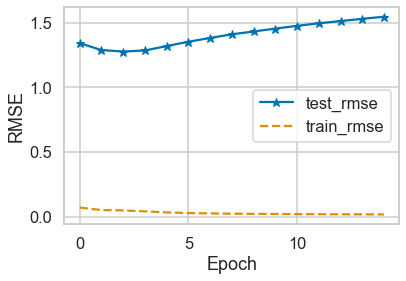

In [35]:
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# (2) MLP Implementation:

In [36]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run MLP.")
    parser.add_argument('--path', nargs='?', default='Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=100,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--layers', nargs='?', default='[64,32,16,8]',
                        help="Size of each layer. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
    parser.add_argument('--reg_layers', nargs='?', default='[0,0,0,0]',
                        help="Regularization for each layer")
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_args()

sys.argv = ['MLP.py','--dataset','Toronto','--epochs','15','--batch_size','256','--layers','[64,32,16,8]',
'--reg_layers','[0,0,0,0]', '--lr','0.001','--learner','adam','--verbose','1','--out','0']

args = parse_args()
dataset = args.dataset
layers = eval(args.layers)
reg_layers = eval(args.reg_layers)
learner = args.learner
learning_rate = args.lr
batch_size = args.batch_size
num_epochs = args.epochs
verbose = args.verbose
evaluation_threads = 1 # mp.cpu_count()

print("MLP arguments: %s" %(args))

MLP arguments: Namespace(batch_size=256, dataset='Toronto', epochs=15, layers='[64,32,16,8]', learner='adam', lr=0.001, out=0, path='Data/', reg_layers='[0,0,0,0]', verbose=1)


In [37]:
def get_mlp_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    fan_input = Input(shape=(1,), dtype = 'int32', name = 'fan_input')

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0] / 2), name = 'user_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0] / 2), name = 'item_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Fans = Embedding(input_dim = num_users, output_dim = int(layers[0] / 2), name = 'fan_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    fan_latent = Flatten()(MLP_Embedding_Fans(fan_input))
    
    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate()([user_latent, item_latent, fan_latent])
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs = [user_input, item_input, fan_input], outputs = prediction)
    
    return model

In [38]:
# Build model
model = get_mlp_model(num_users, num_items, layers, reg_layers)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7727, Test R2 = -0.9042


In [39]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_mlp = current_folder + '\Pretrain\%s_MLP_%d_%d.h5' %(args.dataset, num_factors, time())

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, fan_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, fan_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]))
    
    t2 = time()

    # Evaluation
    if epoch % verbose == 0:
        (mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
        
        test_rmse.append(np.sqrt(mse))
        test_r2.append(r2)
        
        print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
              % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))
        
        if mse < best_mse:
            best_mse, best_r2, best_iter = mse, r2, epoch + 1
            if args.out > 0:
                model.save_weights(model_out_file_mlp, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if args.out > 0:
    print("The best MLP model is saved")

C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [3.8 s]: Test RMSE = 1.1678, Test R2 = 0.1736, Train Loss = 0.2149 [0.1 s]
Epoch 2 [2.9 s]: Test RMSE = 1.1529, Test R2 = 0.1946, Train Loss = 0.1943 [0.1 s]
Epoch 3 [2.9 s]: Test RMSE = 1.1532, Test R2 = 0.1942, Train Loss = 0.1900 [0.1 s]
Epoch 4 [3.0 s]: Test RMSE = 1.1595, Test R2 = 0.1854, Train Loss = 0.1858 [0.1 s]
Epoch 5 [3.0 s]: Test RMSE = 1.1771, Test R2 = 0.1604, Train Loss = 0.1808 [0.1 s]
Epoch 6 [3.6 s]: Test RMSE = 1.1891, Test R2 = 0.1432, Train Loss = 0.1743 [0.1 s]
Epoch 7 [4.3 s]: Test RMSE = 1.2146, Test R2 = 0.1061, Train Loss = 0.1662 [0.1 s]
Epoch 8 [4.2 s]: Test RMSE = 1.2395, Test R2 = 0.0691, Train Loss = 0.1576 [0.1 s]
Epoch 9 [4.6 s]: Test RMSE = 1.2615, Test R2 = 0.0357, Train Loss = 0.1491 [0.4 s]
Epoch 10 [4.2 s]: Test RMSE = 1.2792, Test R2 = 0.0084, Train Loss = 0.1411 [0.1 s]
Epoch 11 [4.2 s]: Test RMSE = 1.2933, Test R2 = -0.0135, Train Loss = 0.1341 [0.1 s]
Epoch 12 [4.3 s]: Test RMSE = 1.3141, Test R2 = -0.0464, Train Loss = 0.1279 [0.1 s]

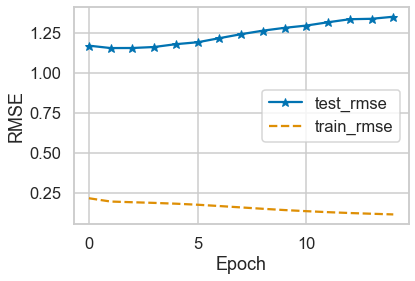

In [40]:
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# NCF Implementation:

In [41]:
#################### Arguments ####################
def parse_args():
    parser = argparse.ArgumentParser(description="Run NeuMF.")
    
    parser.add_argument('--path', nargs='?', default='Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=100,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--num_factors', type=int, default=8,
                        help='Embedding size of MF model.')
    parser.add_argument('--layers', nargs='?', default='[64,32,16,8]',
                        help="MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
    parser.add_argument('--reg_mf', type=float, default=0,
                        help='Regularization for MF embeddings.')                    
    parser.add_argument('--reg_layers', nargs='?', default='[0,0,0,0]',
                        help="Regularization for each MLP layer. reg_layers[0] is the regularization for embeddings.")
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    parser.add_argument('--mf_pretrain', nargs='?', default='',
                        help='Specify the pretrain model file for MF part. If empty, no pretrain will be used')
    parser.add_argument('--mlp_pretrain', nargs='?', default='',
                        help='Specify the pretrain model file for MLP part. If empty, no pretrain will be used')
    return parser.parse_args()


sys.argv = ['NeuMF.py','--dataset','Toronto','--epochs','15','--batch_size','256','--num_factors','8',
            '--layers','[64,32,16,8]','--reg_mf','0','--reg_layers','[0,0,0,0]',
            '--lr','0.001','--learner','adam','--verbose','1','--out','0',
            '--mf_pretrain', '', '--mlp_pretrain', '']

args = parse_args()

num_epochs = args.epochs
batch_size = args.batch_size
mf_dim = args.num_factors
layers = eval(args.layers)
reg_mf = args.reg_mf
reg_layers = eval(args.reg_layers)
learning_rate = args.lr
learner = args.learner
verbose = args.verbose
mf_pretrain = args.mf_pretrain
mlp_pretrain = args.mlp_pretrain

evaluation_threads = -1 # mp.cpu_count()

print("NeuMF arguments: %s " %(args))

NeuMF arguments: Namespace(batch_size=256, dataset='Toronto', epochs=15, layers='[64,32,16,8]', learner='adam', lr=0.001, mf_pretrain='', mlp_pretrain='', num_factors=8, out=0, path='Data/', reg_layers='[0,0,0,0]', reg_mf=0.0, verbose=1) 


In [42]:
def get_ncf_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    fan_input = Input(shape=(1,), dtype='int32', name = 'fan_input')
    
    print('Input layer: ', user_input.shape, user_input.dtype, fan_input.shape)
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)  
    MF_Embedding_Fan = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_fan_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Fan = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = 'mlp_fan_embedding',
                                  embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                  input_length=1)

    output = MLP_Embedding_User(user_input)
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_fan_latent = Flatten()(MF_Embedding_Fan(fan_input))
    
    mf_vector = Multiply()([mf_user_latent, mf_item_latent, mf_fan_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_fan_latent = Flatten()(MLP_Embedding_Fan(fan_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, mlp_fan_latent])
    
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
    model = Model(inputs = [user_input, item_input, fan_input], outputs = prediction)
    
    return model

def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
    # MF embeddings
    gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
    gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
    model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
    model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
    # MLP embeddings
    mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
    mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
    model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
    model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
    # MLP layers
    for i in range(1, num_layers):
        mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
        model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('prediction').get_weights()
    mlp_prediction = mlp_model.get_layer('prediction').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
    return model

In [43]:
# Build and compile, and check initial performance
model = get_ncf_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Load pretrain model
if mf_pretrain != '' and mlp_pretrain != '':
    gmf_model = get_gmf_model(num_users,num_items,mf_dim)
    gmf_model.load_weights(mf_pretrain)
    mlp_model = get_mlp_model(num_users,num_items, layers, reg_layers)
    mlp_model.load_weights(mlp_pretrain)
    model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
    print("Load pretrained GMF (%s) and MLP (%s) models done. " %(mf_pretrain, mlp_pretrain))
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Input layer:  (None, 1) <dtype: 'int32'> (None, 1)
Initial: Test RMSE = 1.7302, Test R2 = -0.8140


In [44]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\Pretrain\%s_NeuMF_%d_%s_%d.h5' %(args.dataset, mf_dim, args.layers, time())

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

for epoch in range(num_epochs):
    t1 = time()
    
    # Generate training instances
    user_input, item_input, fan_input, ratings = get_train_instances(X_train, y_train)
    
    # Training
    history = model.fit([user_input, item_input, fan_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]))
    
    t2 = time()

    # Evaluation
    if epoch % verbose == 0:
        (mse, r2) = evaluate_model(model, X_test, y_test, evaluation_threads)
        
        test_rmse.append(np.sqrt(mse))
        test_r2.append(r2)
        
        print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train Loss = %.4f [%.1f s]' 
              % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))
        
        if mse < best_mse:
            best_mse, best_r2, best_iter = mse, r2, epoch
            if args.out > 0:
                model.save_weights(model_out_file_ncf, overwrite=True)

print("End. Best Iteration %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if args.out > 0:
    print("The best NeuMF model is saved")

C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [6.5 s]: Test RMSE = 1.1644, Test R2 = 0.1784, Train Loss = 0.2116 [0.1 s]
Epoch 2 [4.8 s]: Test RMSE = 1.1516, Test R2 = 0.1965, Train Loss = 0.1940 [0.1 s]
Epoch 3 [4.8 s]: Test RMSE = 1.1524, Test R2 = 0.1953, Train Loss = 0.1878 [0.1 s]
Epoch 4 [4.8 s]: Test RMSE = 1.1911, Test R2 = 0.1403, Train Loss = 0.1728 [0.1 s]
Epoch 5 [4.7 s]: Test RMSE = 1.2425, Test R2 = 0.0646, Train Loss = 0.1518 [0.1 s]
Epoch 6 [4.7 s]: Test RMSE = 1.2672, Test R2 = 0.0269, Train Loss = 0.1358 [0.1 s]
Epoch 7 [4.9 s]: Test RMSE = 1.3032, Test R2 = -0.0291, Train Loss = 0.1239 [0.1 s]
Epoch 8 [5.4 s]: Test RMSE = 1.3288, Test R2 = -0.0699, Train Loss = 0.1147 [0.1 s]
Epoch 9 [4.7 s]: Test RMSE = 1.3597, Test R2 = -0.1203, Train Loss = 0.1071 [0.1 s]
Epoch 10 [4.8 s]: Test RMSE = 1.3606, Test R2 = -0.1218, Train Loss = 0.1009 [0.1 s]
Epoch 11 [4.7 s]: Test RMSE = 1.3745, Test R2 = -0.1448, Train Loss = 0.0958 [0.1 s]
Epoch 12 [4.8 s]: Test RMSE = 1.3896, Test R2 = -0.1701, Train Loss = 0.0915 [0.

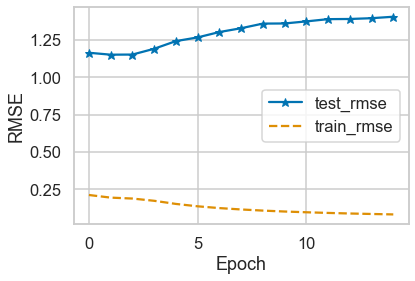

In [45]:
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()